<a href="https://colab.research.google.com/github/eikeschuett/IcebergShipDetection/blob/main/Ship_Iceberg_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# License

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation version 3 of the License.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
[GNU General Public License](https://choosealicense.com/licenses/gpl-3.0/) for more details.

# Overview



**Topic**: Iceberg and ship detection with satellite imagery

**Goal**: This project is aimed at building an algorithm for the detcetion of ships and icebergs in Sentinel-1 SAR imagery. Desired output is a map, which shows the locations of icebergs, ships and unidentified objects.

**Details**: The dataset used for training is obtained from a Kaggle challenge, [Statoil/C-CORE Iceberg Classifier](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge). Each image has 75x75 pixels with two bands from HH and HV polarisations and contains a ship or an iceberg. This dataset will be used to train a CNN. After training the classification model, we will use Sentinel-1 SAR images to show the "real world application" of our model. The satellite images will be pre-processed with the Sentinel Application Platform (SNAP) Python API. We will then identify bright objects within each satellite image. A 75x75 subset of the radar image will be made for each object and fed into our classification model. Finally, the results will be plotted on a map.

The program is uploaded on a public GitHub repository: [`eikeschuett/IcebergShipDetection`](https://github.com/eikeschuett/IcebergShipDetection)

# Dataset
This project used the satellite SAR imagery provided by Kaggle challenge, [Statoil/C-CORE Iceberg Classifier](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge).
The dataset information is saved in the json file containing the following fields (see Table 1):
* id: the id of the image 
* band_1 & band_2: the flattened image data. Each band has 75x75 pixel values in the list. The values are float numbers with unit being dB with the physical meaning of backscatter coefficient, $\sigma^0$. band_1 and band_2 represent for HH-polarisation and HV polarisation, respectively (see Figure 1 below for having an idea of how the image looks like).
* inc_angle: the incidence angle (see Figure 2). This field has missing data mark as "na", in our project, we gave the "na" a default value of 30°.
* is_iceberg: the target variable, set to 1 if it is an iceberg, and 0 if it is a ship. 

> **Table 1**: A glimpse of `train.json` file <br>

| id |band_1 | band_2 | inc_angle | is_iceberg |
| --------- | ---- | ---------------- | --------------- | ---------------- |
|dfd5f913 |	[-27.878360999999998, -27.15416, -28.668615, -... |	[-27.154118, -29.537888, -31.0306, -32.190483,... |	43.9239 |	0 |
|e25388fd |	[-12.242375, -14.920304999999999, -14.920363, ... |	[-31.506321, -27.984554, -26.645678, -23.76760... |	38.1562 | 0 |
|58b2aaa0 |	[-24.603676, -24.603714, -24.871029, -23.15277... |	[-24.870956, -24.092632, -20.653963, -19.41104... |	45.2859 |	1 |
|4cfc3a18 |	[-22.454607, -23.082819, -23.998013, -23.99805... |	[-27.889421, -27.519794, -27.165262, -29.10350... |	43.8306 |	0 |
|271f93f4 |	[-26.006956, -23.164886, -23.164886, -26.89116... |	[-27.206915, -30.259186, -30.259186, -23.16495... |	35.6256 |	0 |



As the field is_iceberg only exists in `train.json` but not `test.json`, this project only used `train.json` and separated the dataset into training, validation and test datasets with the proportion of $7:2:1$.


In [ ]:
%%html
<IMG SRC="https://raw.githubusercontent.com/eikeschuett/IcebergShipDetection/main/pic/image_ice-berg.png" border="0"></a>
<IMG SRC="https://raw.githubusercontent.com/eikeschuett/IcebergShipDetection/main/pic/image_ship.png" border="0"></a>


> **Figure 1**: Examples of SAR images with iceberg and ship in Kaggle dataset.

In [ ]:
%%html
<IMG SRC="https://earth.esa.int/handbooks/asar/aux-files/ephimg-10418557.gif" border="0"></a>

> **Figure 2**: Illustration of incidence angle (source: [ESA earthnet](https://earth.esa.int/handbooks/asar/CNTR5-5.html)).

# Method


## Normalization

This study applied incidence angle normalization method [(Topouzelis et al., 2016)](https://www.degruyter.com/view/journals/geo/8/1/article-p450.xml?tab_body=abstract) to normalize the backscatter coefficient from band_1 (HH) and band_2 (HV) using:

$\sigma_{\theta, norm}^0=\dfrac{\sigma_\theta^0+(0.766\theta-31.638)}{2}$

where<br>
> $\theta$: incidence angle<br>
> $\sigma^0_\theta$: backscatter coefficient at incidence angle $\theta$<br>



## Band 3 Generation

This project test different combinations of HH and HV polarisations data for generating the 3rd bands. 
Addition (+), subtraction (-), multiplication (\*) and division (/) were applied in the test stage.
Addition calculation $HH + HV$ is also known as the **total backscatter**.

According to [Heiselberg (2020)](https://www.mdpi.com/2072-4292/12/15/2353), the **cross polarisation ratio** $C = HV / (HH+HV)$ is a commonly used spatial feature in Ship-Iceberg Classification. 
Thus, the cross polarisation ratio was also applied in the test stage. 
Figure 3 shows loss and accuracy charts applying different generations of band 3.

Check the program [CNN_test_different_3rd_bands_c.ipynb on CNN_Trail_and_Error branch](https://github.com/eikeschuett/IcebergShipDetection/blob/DNN_Trial_and_Error/CNN_test_different_3rd_bands_c.ipynb).




In [ ]:
%%html
<IMG SRC="https://raw.githubusercontent.com/eikeschuett/IcebergShipDetection/main/pic/bands.png" border="0"></a>


> **Figure 3**: Comparing the training results with different band 3.

Most promising combinations are total backscatter HH+HV and cross polarisation ratio HV/(HH+HV) with the validation accuracies 0.860 and 0.866, respectively.

## Image Denoising
Differrnt filters for initial image denoising have been tested in this projecet.
Figure 4 shows the examples of how filters work on ship images and iceberg images.
Figure 5 shows the loss and accuracy charts applying different filters.

Check the program [CNN_test_different_speckle_filters on CNN_Trail_and_Error branch](https://github.com/eikeschuett/IcebergShipDetection/blob/DNN_Trial_and_Error/CNN_test_different_speckle_filters.ipynb).

In [ ]:
%%html
<IMG SRC="https://raw.githubusercontent.com/eikeschuett/IcebergShipDetection/main/pic/filter_iceberg.png" height="520" border="0"></a>
<IMG SRC="https://raw.githubusercontent.com/eikeschuett/IcebergShipDetection/main/pic/filter_ship.png" height="520" border="0"></a>

> **Figure 4**: Examples of filterd SAR images.

In [ ]:
%%html
<IMG SRC="https://raw.githubusercontent.com/eikeschuett/IcebergShipDetection/main/pic/filter.png" border="0"></a>

> **Figure 5**: Comparing the training results with different filters: no filter, bilateral filter, Gaussian filter and Lee filter.

There are not much differecne between the training results, but bilateral filter and Lee filter appear to denoise best. 
As bilateral filter is more time-consuming, this project applied **Lee filter**.

## Optimizer Decision
This project has tested the loss function Binary cross entropy with different optimizers, RMSProp, Adam, SGD and SGD with nesterov momentum, on training our ship-iceberg classifier.
Figure 6 shows the loss and accuracy charts applying different optimizers.

Check the program [CNN_test_different_optimizers.ipynb on the CNN_Trail_and_Error branch](https://github.com/eikeschuett/IcebergShipDetection/blob/DNN_Trial_and_Error/CNN_test_different_speckle_filters.ipynb).

In [ ]:
%%html
<IMG SRC="https://raw.githubusercontent.com/eikeschuett/IcebergShipDetection/main/pic/optimizer.png" border="0"></a>


> **Figure 6**: Comparing the training results with different optimizers: Adam, SGD, SGD with nesterov momentum and RMSProp.




The curves of the loss of SGD+Nesterov and RMSprop is quite jaggy. 
Adam learns fast in the beginning but shows overfitting after approx. 250 to 300 epochs. 
SGD needs more epochs to get nice results, but its curves look the best after 500 epochs.
Table 2 shows the test accuracies with different optimizers

> **Table 2**: Test accuracies with different optimizers

|               | Adam |  SGD | SGD+Nesterov | RMSprop |
|---------------|------|------|--------------|---------|
| Test Accuracy | 0.83 | 0.87 |     0.89     |   0.86  |

Experiences with other models show that Adam is more stable than SGD. This project used **Adam** and paid attention to potential overfitting.

# Outline

1. Download the Kaggle dataset to Google Drive with Kaggle API
2. Build up the CNN architecture for training
3. Train the model
4. Test with real world data

# Download the Kaggle dataset to Google Drive

Following the steps: https://www.kaggle.com/general/74235

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/

Go to your account in Kaggle, scroll to API section and click  on "Create New API Token". Then, the file `kaggle.json` will be downloaded into your local drive, upload it with `files.upload()`.

In [ ]:
from google.colab import files
files.upload()

Make directory named kaggle and copy `kaggle.json` file there.

In [ ]:
!mkdir -p kaggle
!mv kaggle.json kaggle
%cd kaggle/

Download the data to the directory `/content/drive/MyDrive/kaggle/data`

In [ ]:
!mkdir -p data
%cd data
!kaggle competitions download -c carvana-image-masking-challenge

Unzip the *.7z file with the build-in command.

In [ ]:
!7z e test.json.7z 
!7z e train.json.7z 
!7z e sample_submission.csv.7z 

Folder Structure on Google Drive
```
MyDrive/
    kaggle/
        data/
            train.json.7z
            test.json.7z
            sample_submission.csv.7z
            train.json
            test.json
            sample_submission.csv
```

Note that `test.json` data doesn't contain the label `is_iceberg`, so this project only use `train.json` and split the data into training, validation and test data.

# Prepare Data and Model

Import the required libraries

In [ ]:
import numpy as np
np.random.seed(666)
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

Mount the drive and import the data.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
#data = pd.read_json('/content/drive/MyDrive/kaggle/data/train.json')

data = pd.read_json('/content/drive/MyDrive/Iceberg_Ship_Classification/train.json')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


As the first thing, check if we have an unbalanced dataset.

In [ ]:
print(len(data))
print(round(np.sum(data.is_iceberg)/len(data)*100,3))

1604
46.945


47 % of all images are icebergs, which is a bit unbalanced.

Next, drop all images which don't have an incidence angle.

In [ ]:
data.inc_angle = data.inc_angle.replace('na', np.nan)
data = data.dropna(axis=0, how='any')
print(len(data))
print(round(np.sum(data.is_iceberg)/len(data)*100,3))

1471
51.19


We lost 133 images, all of them were ships. As a result, our dataset is a bit smaller but also a bit more balanced.

Now, define a function to normalize the HH and HV bands to the incidence angle later.

In [ ]:
def normalize(sig_nought, inc_angle):
    """
    :type sig_nought: np.ndarray(np.float)
    :type inc_angle: float
    """
    sig_nought_n = (sig_nought + 0.766 * inc_angle - 31.638) / 2

    return sig_nought_n


We also define a function for the Lee filter which we have from [here](https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python).

In [ ]:
def lee_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

Then we define a function for the data preparation. This function does the following:


*   reshape flattened images into 75x75 format
*   normalize HH and HV bands
*   create an array with the total backscatter (b3)
*   create an array with the cross polarization ratio (c3)
*   apply the Lee-filter to all bands
*   rescale all arrays between 0 and 1 (since we use ReLu activation function later)
*   stack the arrays a 4-band image
*   split the data into training (70 %), validation (20%) and test (10 %) datasets

In [ ]:
def normalize_data(hh, hv, inc_angle):
  # normalize hh and hv using inc_angle (x_angle[i])
  hh = normalize(hh, inc_angle)
  hv = normalize(hv, inc_angle)

  # apply Lee filter for all bands
  hh = lee_filter(hh, 20)
  hv = lee_filter(hv, 20)

  # total backscatter = hh + hv
  b3 = hh + hv
  # cross polarisation ratio = hv / (hh+hv)
  c3 = hv / 2*(hh+hv)
                  
  # Rescale images between 0 and 1 for faster convergence rate
  hh = (hh - hh.min())/(hh.max()-hh.min())
  hv = (hv - hv.min())/(hv.max()-hv.min())
  b3 = (b3 - b3.min())/(b3.max()-b3.min())
  c3 = (c3 - np.nanmin(c3))/(np.nanmax(c3)-np.nanmin(c3))  
  return hh, hv, b3, c3

In [ ]:
def prepare_data(data):
    x_angle = np.array(data["inc_angle"])

    # Create empty list for the images
    imgs = []
    labels = []

    for i, row in data.iterrows():
      if not np.isnan(row["inc_angle"]):
        labels.append(row["is_iceberg"])
        # Reshape list to image
        hh  = np.reshape(row["band_1"], (75, 75))
        hv  = np.reshape(row["band_2"], (75, 75))

        hh, hv, b3, c3 = normalize_data(hh, hv, row["inc_angle"])

        # Stack the bands and append them to imgs
        imgs.append(np.dstack((hh, hv, b3, c3)))
    
    labels = np.array(labels)
    
    # Split dataset into training (70%) and validation (30 %)                             
    x_train, x_val, y_train, y_val = train_test_split(imgs, labels,
                                                     test_size=0.3,
                                                     random_state=0)
    # Then split validation dataset into validation (20 %) and testing (10 %)
    x_val, x_test, y_val, y_test = train_test_split(x_val, y_val,
                                                     test_size=(1/3),
                                                     random_state=0)                               
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    x_val = np.array(x_val)
    
    return x_train, x_val, x_test, y_train, y_val, y_test

Now prepare the data

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = prepare_data(data)
print("Number of samples for training: %i (%.2f%%)"%(len(x_train), round(len(x_train)/len(data)*100)))
print("Number of samples for validation: %i (%.2f%%)"%(len(x_val), round(len(x_val)/len(data)*100)))
print("Number of samples for testing: %i (%.2f%%)"%(len(x_test), round(len(x_test)/len(data)*100)))

Number of samples for training: 1029 (70.00%)
Number of samples for validation: 294 (20.00%)
Number of samples for testing: 148 (10.00%)


To prevent overfitting, we use image augmentation and set up an image data generator for this.

In [ ]:
batch_size = 32
gen = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

gen_flow = gen.flow(x_train, y_train, batch_size = batch_size, seed = 666)


Now define our model. It's a sequential model with four convolutions, MaxPoolings and Dropouts in the beginning. Next comes a GlobalMaxPooling and three Dense layers, each with 64 neurons. The output layer is a single neuron with a sigmoid activation function.

In [ ]:
def create_model(optimizer):
    input_img   = Input(shape=(75, 75, 4), name="X_img")

    cnn = Conv2D(16, kernel_size=(3,3), activation = "relu")(input_img)
    cnn = MaxPooling2D((2,2))(cnn)
    cnn = Dropout(0.1) (cnn)

    cnn = Conv2D(32, kernel_size=(3,3), activation = "relu")(cnn)
    cnn = MaxPooling2D((2,2))(cnn)
    cnn = Dropout(0.1)(cnn)

    cnn = Conv2D(64, kernel_size=(3,3), activation = "relu")(cnn)
    cnn = MaxPooling2D((2,2))(cnn)
    cnn = Dropout(0.1)(cnn)  

    cnn = Conv2D(128, kernel_size=(3,3), activation = "relu")(cnn)
    cnn = Conv2D(128, kernel_size=(3,3), activation = "relu") (cnn)
    cnn = MaxPooling2D((2,2))(cnn)
    cnn = Dropout(0.1)(cnn)  
    
    cnn = Flatten()(cnn)

    dense = Dense(64, activation="relu")(cnn)
    dense = Dense(64, activation="relu") (dense)
    dense = Dense(64, activation="relu") (dense)

    output = Dense(1, activation="sigmoid")(dense)

    model = Model(input_img, output)

    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

model = create_model(optimizer = Adam())
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_img (InputLayer)           [(None, 75, 75, 4)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 73, 73, 16)        592       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 34, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 17, 32)        0     

We will train for 300 epochs, but the training may stop as soon as the validation loss levels off. For this we will use the Early Stopping Callback.

In [ ]:
def get_callbacks(patience=5):
    es = EarlyStopping('val_loss', patience=patience, mode="auto", restore_best_weights=True)
    return es

callbacks = get_callbacks(patience=50)

# Train the Model

In [ ]:
epochs = 300

history = model.fit(gen_flow, 
                    validation_data=(x_val, y_val),
                    steps_per_epoch=len(x_train) / batch_size, 
                    epochs=epochs,
                    callbacks=callbacks)

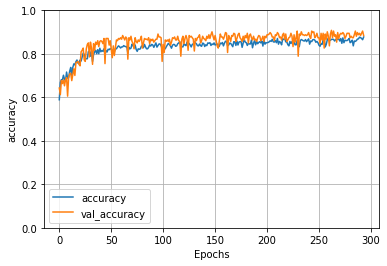

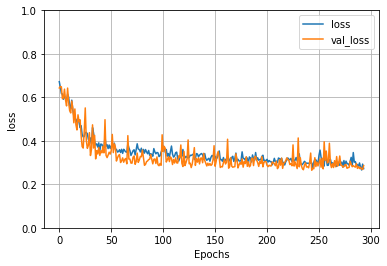

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string], loc = 'best')
  plt.ylim([0,1])
  plt.grid()
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
results = model.evaluate(x_test, y_test)

5/5 [==============================] - 0s 18ms/step - loss: 0.2401 - accuracy: 0.8986


In [ ]:
model.save("/content/drive/MyDrive/Iceberg_Ship_Classification/model_normalize.hd5")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Iceberg_Ship_Classification/model_normalize.hd5/assets


# Baseline

The original kaggle contest contains a "secret" dataset (without labels) for testing. Because the official contest is finished since three years, we had to compare our model with models, which also only used the labelled dataset. We found two projects:

[An article on towards data science](https://towardsdatascience.com/deep-learning-for-iceberg-detection-in-satellite-images-c667acf4bad0)
- used the raw data (i.e. no third band, pre-filtering, or normalization to the incidence angle)
- used a non-sequential model
- incidence angle was used as a separate input feature

[A paper by Heiselberg (2020)](https://www.mdpi.com/2072-4292/12/15/2353)
- used a different cross-polarization ratio
- no pre-filtering
- did not used the incidence angle at all
- two different sequential models (CNNs)

> **Table 3**: Accuracies of our baselines.

|  Model             | Train ACC |  Test ACC |
|--------------------|-----------|-----------|
| TowardsDataScience | 0.90      | 0.85      |
| Heiselberg CNN1    | 0.87      | 0.86      |
| Heiselberg CNN2    | 0.94      | 0.88      |
| Our model          | 0.88      | 0.90      |

The improvements in our project were:<br>
- Consider total scatter and cross polarisation ratio as band 3 and band 4
- Apply normalization by using the provided incidence angle
- Achieve better accuracy 89.86% on test set 


# Test with real world data

## Ship and Iceberg in the real world
With our knowledge about sea ice and ship detection, this project tested with the real-world data in Disko Bay (see Figure 7 for the geolocation), which is a hotspot for icebergs on the west coast of Greenland. 

In [ ]:
%%html
<IMG SRC="https://raw.githubusercontent.com/eikeschuett/IcebergShipDetection/main/pic/Map_test_area_zoomout.jpg"  height="320" border="0"></a>
<IMG SRC="https://raw.githubusercontent.com/eikeschuett/IcebergShipDetection/main/pic/Map_test_area.jpg" height="320" border="0"></a>

> **Figure 7**: Location of Disko Bay

This project tested with the real world Sentinel-1 GRD data downloaded from  [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home).
Table 4 lists the information of the test scene.
Figure 8 shows its coverage on the map.


> **Table 4**: Information of the test scene

| Information | Test scene |
|--|--|
| filename | S1A_IW_GRDH_1SDH_20210115T100027_20210115T100052_036147_043CF4_049C |
| Pass Direction | Descending |
| Product Type | GRD |
| Polarisation | HH HV |
| Absolute Oribt | 36147 |
| Relative Orbit | 25 |
| Sening Time | 2021-01-15T10:00 | 



In [ ]:
%%html
<IMG SRC="https://raw.githubusercontent.com/eikeschuett/IcebergShipDetection/main/pic/Map_Iceberg_Ship_Classifier_S1A_IW_GRDH_1SDH_20210115T1000_subset_area.png" height="500" border="0"></a>

> **Figure 8**: The coverage of the test scene

## Preprocessing 
This project followed a standard generic workflow to pre-process  Sentinel-1 GRD data according to [Filipponi (2019)](https://www.mdpi.com/2504-3900/18/1/11) using [Sentinel Application Platform (SNAP)](https://step.esa.int/main/toolboxes/snap/) Python API.

The preprocessing steps in this project contains:
1. Apply Orbit file
2. Subset if required
3. Calibration
4. Convert to dB
5. Land-Sea-Mask

The incidence angles of the images were saved as a TIFF files during pre-processing step as well.

Check the pre-processing program for more details: [preprocessing_s1_scene.py](https://github.com/eikeschuett/IcebergShipDetection/blob/main/preprocessing_s1_scene.py)



## Object detection

If required, import the model.

In [ ]:
# model = load_model('/content/drive/MyDrive/Iceberg_Ship_Classification/model_normalize.hd5')


First, import all additionally required libraries.

In [ ]:
import os
from PIL import Image
import skimage.measure as measure
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import zipfile

We already mounted the drive and defined a function for the Lee-filter. 

The next step is to import the satellite image. The pre-processed image contains five bands (HH, HV, incidence angle, Latitude, Longitude), which are stored in separate tif-files in a zip-file. We will unzip this file and import the individual bands.

In [ ]:
# Path to .zip file in my mounted drive
path = "/content/drive/MyDrive/Iceberg_Ship_Classification/Testscenes/"
# Disko bay with icebergs
file = "S1A_IW_GRDH_1SDH_20210115T100027_20210115T100052_036147_043CF4_049C_output.zip" 
#Svalbard scene with ship in the center
#file = "S1B_IW_GRDH_1SDH_20210108T154500_20210108T154525_025065_02FBC6_38D2_output.zip"

# Create temporary working diretory in colab
wdir = "/content/" + file[:-4]
if not os.path.exists(wdir):
    os.makedirs(wdir)
os.chdir(wdir)

with zipfile.ZipFile(path+file, 'r') as zip_ref:
    zip_ref.extractall() # Unzip in working directory

# Import bands
hh = np.array(Image.open(file[:-11] + '_cal_ter_db_UTM_msk_Sigma0_HH_db.tif'))
hv = np.array(Image.open(file[:-11] + '_cal_ter_db_UTM_msk_Sigma0_HV_db.tif'))
inc_angle = np.array(Image.open(file[:-11] + '_cal_ter_db_UTM_msk_IncidenceAngle.tif'))
# Also import the arrays containing the latitude and longtitude data.
lat = np.array(Image.open(file[:-11] + '_cal_ter_db_UTM_msk_lat.tif'))
lon = np.array(Image.open(file[:-11] + '_cal_ter_db_UTM_msk_lon.tif'))



Then, the bands need to be prepared in the same way as our training data.

In [ ]:
hh, hv, b3, c3 = normalize_data(hh, hv, inc_angle)

Let's see what our scene looks like.

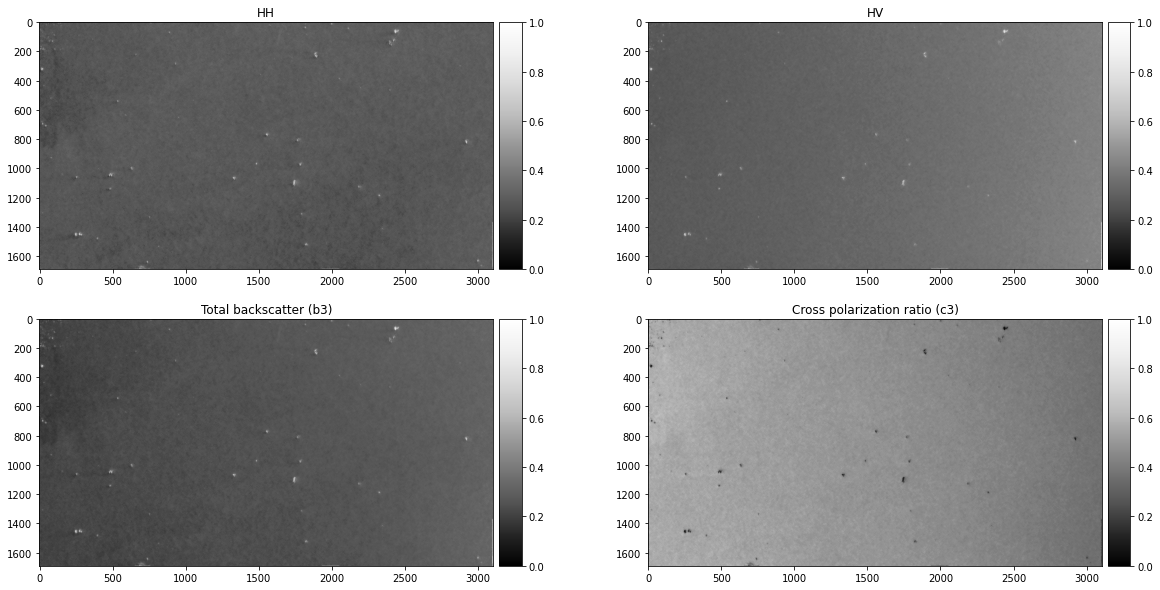

In [ ]:
def plot_axes(x, y, data, title):
  ax_p = axes[x, y].imshow(data, cmap="Greys_r")
  divider = make_axes_locatable(axes[x,y])
  cax = divider.append_axes("right", size="5%", pad=0.08)
  fig.colorbar(ax_p, ax=axes[x,y], cax=cax)
  axes[x,y].set_title(title)


fig, axes = plt.subplots(2,2, figsize=(20,10))
plot_axes(0,0, hh, 'HH')
plot_axes(0,1, hv, 'HV')
plot_axes(1,0, b3, 'Total backscatter (b3)')
plot_axes(1,1, c3, 'Cross polarization ratio (c3)')
plt.show()


Some bright objects are in the subset of the scene, most likely icebergs. To extract their position, we will calculate a threshold based on the median and the standard deviation of the total backscatter. This is super simple but works quite well.

In [ ]:
thresh = np.median(b3) + 5*np.std(b3)
print(thresh)

0.46723541617393494


All pixels above this threshold are considered to be bight and are likely ships or icebergs.

To extract the locations of the different objects and place a bounding box around them, I create an array with zeros (boring water) and ones (detected object).

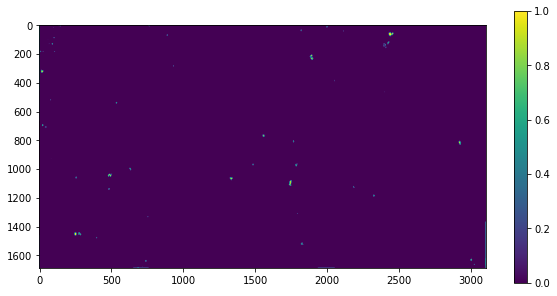

In [ ]:
# Create array of zeros
roi = np.zeros(np.shape(b3))
# Mark all potential objects with ones
roi[b3>thresh] = 1

plt.figure(figsize=(10,5)) 
plt.imshow(roi)
plt.colorbar()
plt.show()

The bright objects visible in the total backscatter plot have been successfully detected.

Several very small objects consisting of just one or two pixels were detected, because the total backscatter of these pixels was above our threshold. These pixels are very likely no real objects but image noise. To get rid of them, a unique value is assigned to each area of pixels with the same value. Then, all very small areas, which consist of less than 3 pixels, are removed from our list of potential objects. Finally, we can get bounding boxes for each detected object.

Some objects (and artefacts due to Lee-Filters behaviour at the edges of the scene) are not fully contained in the scene. Feeding these into the NNs may result in bad predictions because the object is cut off. For this reason, we will remove all objects which are at the edge of the scene.

Number of potential objects before removing small ones: 101

Number of potential objects after removing small ones: 78



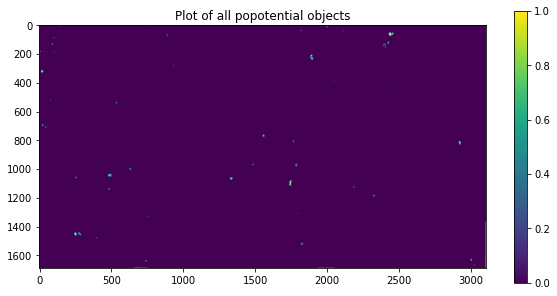


Number of potential objects after removing ones at the edges: 71



In [ ]:
# Assign unique value for each region of same values
roi_labeled = measure.label(roi, connectivity=2)
print("Number of potential objects before removing small ones: " + str(np.max(roi_labeled)))

# Count occurences of unique values
unique, counts = np.unique(roi_labeled, return_counts=True)

# Get index of all regions consisting of less then 5 pixels 
# np where returns a tuple of an np.array, [0] at end gets only the np.array
idx = np.where(counts<3)[0]

# Assign 0 to all pixels in the roi-mask that are only small regions
for i in idx:
    roi[roi_labeled==i] = 0
    
# Assign unique value for each region of same values again, now without the small regions
roi_labeled = measure.label(roi, connectivity=2)
print("\nNumber of potential objects after removing small ones: " + str(np.max(roi_labeled)) + "\n")

plt.figure(figsize=(10,5)) 
plt.imshow(roi)
plt.colorbar()
plt.title("Plot of all popotential objects")
plt.show()

# Get bboxes of each region    
bboxes = [area.bbox for area in measure.regionprops(roi_labeled)]

# Remove all bboxes which are at the border of the image (likely not fully within the image)
bboxes = [bound for bound in bboxes if bound[0] > 0 and 
            bound[2]<np.shape(b3)[0] and
            bound[1]>0 and
            bound[3]<np.shape(b3)[1]]

print("\nNumber of potential objects after removing ones at the edges: " + str(len(bboxes)) + "\n")

Prepare python lists for our output and store the edges of the satellite scene in it.


In [ ]:
geo_output = []

lat_max, lon_max = np.shape(lat)
lat_max = lat_max-1
lon_max = lon_max-1

geo_output.append([lat[0,0], lon[0,0], "upper left corner", np.nan])
geo_output.append([lat[0,lon_max], lon[0,lon_max], "upper right corner", np.nan])
geo_output.append([lat[lat_max,lon_max], lon[lat_max,lon_max], "lower right orner", np.nan])
geo_output.append([lat[lat_max,0], lon[lat_max,0], "lower right corner", np.nan])

Prepare a plot that shows our objects with a different coloured bounding box, depending on the object type. Then, iterate through all the objects, create a 75x75 subset with each object in the centre. This subset is then fed into our model and the result is stored in the python lists.

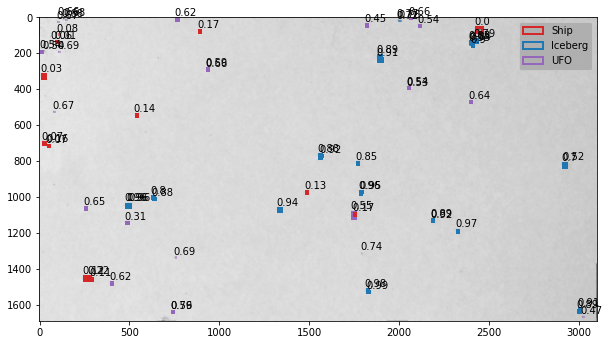

In [ ]:
# Linewidth for Plot
lw = 3

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(b3, cmap="Greys")

for bbox in bboxes:
    # Calculate the extend of bbox
    height = bbox[2]-bbox[0]
    width = bbox[3]-bbox[1]
    # coordinates of upper left pexel of bbox (can be used for plotting)
    ul = [bbox[1], bbox[0]]
    
    # Calculate center of bbox
    c_x = (bbox[0]+bbox[2])/2
    c_y = (bbox[1]+bbox[3])/2
    roi_center = [c_x, c_y]

    # Define extend of 75*75 subset with center of bbox in the middle
    # a = sub_roi
    x1 = round(roi_center[0])-38
    x2 = round(roi_center[0])+37
    y1 = round(roi_center[1])-38
    y2 = round(roi_center[1])+37
    
    # If parts of the subset would be out of bounds of original image, place the subplot at the border of the image
    if x1 < 0:
        x1 = 0
        x2 = 75
    if y1 < 0:
        y1 = 0
        y2 = 75
    
    if x2 > np.shape(b3)[0]:
        x1 = np.shape(b3)[0]-76
        x2 = np.shape(b3)[0]-1
        
    if y2 > np.shape(b3)[1]:
        y1 = np.shape(b3)[1]-76
        y2 = np.shape(b3)[1]-1        
    

    sub_hh = hh[x1:x2, y1:y2]
    sub_hv = hv[x1:x2, y1:y2]
    sub_b3 = b3[x1:x2, y1:y2]
    sub_c3 = c3[x1:x2, y1:y2]    

    sub_img = np.dstack((sub_hh, sub_hv, sub_b3, sub_c3))
    sub_img = np.expand_dims(sub_img, axis=0)

    # feed sub_img into the model to predict
    output = model.predict(sub_img)
    
    #print(output)
    
    if output < 0.3:
        # Ship!
        geo_output.append([lat[int(roi_center[0]), int(roi_center[1])],
                             lon[int(roi_center[0]), int(roi_center[1])],
                             "ship", output[0][0]])
        box = mpatches.Rectangle((ul[0], ul[1]), width, height, 
                                 edgecolor='tab:red', linewidth=lw, fill=None)
    elif output > 0.7:
        # Iceberg!
        geo_output.append([lat[int(roi_center[0]), int(roi_center[1])],
                             lon[int(roi_center[0]), int(roi_center[1])],
                             "iceberg", output[0][0]])
        box = mpatches.Rectangle((ul[0], ul[1]), width, height, 
                                 edgecolor='tab:blue', linewidth=lw, fill=None)
    else:
        # unidentified floating object
        geo_output.append([lat[int(roi_center[0]), int(roi_center[1])],
                             lon[int(roi_center[0]), int(roi_center[1])],
                             "UFO", output[0][0]])
        box = mpatches.Rectangle((ul[0], ul[1]), width, height, 
                                 edgecolor='tab:purple', linewidth=lw, fill=None)
    
    ax.add_patch(box)
    ax.text(ul[0]-10, ul[1]-15, str(round(output[0][0],2)))



# Add legend to plot
l1 = mpatches.Patch(edgecolor='tab:red', facecolor='None', lw=2, label='Ship')
l2 = mpatches.Patch(edgecolor='tab:blue', facecolor='None', lw=2, label='Iceberg')
l3 = mpatches.Patch(edgecolor='tab:purple', facecolor='None', lw=2, label='UFO')
legend = ax.legend(handles=[l1, l2, l3], loc='upper right')

legend.legendPatch.set_facecolor('darkgrey')

plt.show()

Finally, save the output-table as a csv-file and prepare a nice geographic map (e.g. with QGIS or cartopy in python). Unfortunately, cartopy won't run in Google Colab, but you can [this Python Code from our GitHub Repository](https://github.com/eikeschuett/IcebergShipDetection/blob/main/final_result_map.py) to produce a map in your own local python environment.

In [ ]:
geo_output = pd.DataFrame(geo_output,columns=['lat', 'lon', 'object', 'probability'])
geo_output.to_csv("/content/drive/MyDrive/Iceberg_Ship_Classification/geo_output_" + file[:-11] +  ".csv", sep="\t", index=False)
geo_output.tail()


,lat,lon,object,probability
70,69.106056,-54.071953,iceberg,0.909650
71,69.104958,-54.071983,iceberg,0.886713
72,69.069099,-53.513050,iceberg,0.757720
73,69.069145,-53.512264,UFO,0.593759
74,69.102531,-54.078781,UFO,0.472627


And here it is: Figure 9 shows our final output! 

In [ ]:
%%html
<IMG SRC="https://raw.githubusercontent.com/eikeschuett/IcebergShipDetection/main/pic/Map_Iceberg_Ship_Classifier_S1A_IW_GRDH_1SDH_20210115T1000.png"  width="800" border="0"></a>

> **Figure 9**: The results of iceberg-ship classification

## Comparison with the ground truth data

Larger ships have to be equipped with AIS (Automatic Identification System), a VHF-based tracking system that provides information on e.g. the position and the speed of each vessel. In the Disko Bay no land-based AIS stations exist so that only satellite AIS data is available. 

Unlike the data from land stations, important parameters of satellite AIS data is not shared freely on the internet. We only get an information of the position of a vessel and its type, but not the vessels name and the time of the last position report. Satellite AIS positions may be [between a few minutes and an hour old](https://help.marinetraffic.com/hc/en-us/articles/217631867-How-often-do-the-positions-of-the-vessels-get-updated-on-MarineTraffic-).

Figure 10 shows a screenshot of the satellite AIS data from [OpenSeaMap](http://map.openseamap.org), taken at the same time as the Sentinel-1 satellite overpass. We can clearly see that there is a ship halfway between Qeqertarsuaq and Kronprinsen Ejland. 

In [ ]:
%%html
<IMG SRC="https://raw.githubusercontent.com/eikeschuett/IcebergShipDetection/main/pic/Disko_Bay_AIS_20210115_1103_Subset.png"  width="800" border="0"></a>

> **Figure 10**: Screenshot from [OpenSeaMap](http://map.openseamap.org) on 2021-01-15 10:03 UTC showing AIS targets received via satellite.

If you plot the position of the AIS target into our output map, you can clearly see that it corresponds well to the position of one of our detected ships.

In [ ]:
%%html
<IMG SRC="https://raw.githubusercontent.com/eikeschuett/IcebergShipDetection/main/pic/Map_Iceberg_Ship_Classifier_S1A_IW_GRDH_1SDH_20210115T1000_ais_1.png"  width="800" border="0"></a>

> **Figure 11**: The results of iceberg-ship classification along with the ground truth data from [OpenSeaMap](http://map.openseamap.org)

Why are there more ships in our scene than one might expect in this area? Well, there are several posiible explanatons. Firts, only larger, internationally voyaging ships (> 300 GT) must use AIS and it's known that especially fishing boats sometimes turn off their AIS so that other boats can't see where they found fish. Furhter, our model might produce some incorrect predictions for several reasons (issues with traning data, Lee-filters behaviour at edges, etc...)
